# Handwritten Digit recognizer

The purpose of this model is to develop a  Convolutional Neural Network for recognizing handwritten digits


### Import statements

In [1]:
import tensorflow as tf
from keras.preprocessing import image
from keras.utils.vis_utils import plot_model
from tensorflow.python.keras.callbacks import ReduceLROnPlateau

import sys
sys.path.insert(1, "/home/azureuser/DataAnalyzer/src")

"""
Benchmark:
Bug : pour fixer le bug modifier le chemin /home/azureuser/DataAnalyzer/src/modules par /home/azureuser/DataAnalyzer/src : executer
 ensuite réexecuter avec /home/azureuser/DataAnalyzer/src/modules

"""
from src.data.data_validator import *
from src.data.data_processing import *


import string

from matplotlib import pyplot
from sklearn.metrics import confusion_matrix
import seaborn as sns

2022-06-05 12:21:06.650505: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-05 12:21:06.650540: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## The data preparation


In [2]:
sns.set(rc = {'figure.figsize':(15,15)})

### Data Validation

Validate the dataset using the data_validator method

In [3]:

training_path = "/home/azureuser/digit_data/training"
testing_path =  "/home/azureuser/digit_data/testing"
validation_path =  "/home/azureuser/digit_data/validation"

for i in range(10):
    data_validator(training_path   + "/" + str(i))
    data_validator(testing_path    + "/" + str(i))
    data_validator(validation_path + "/"      + str(i))

### Generate directory to read images from & Data augmentation

#### Normalization

To avoid overfitting we will alter our dataset.
We chose :

    - Random rotation by 10° of some training image
    - Zoom/deZoom by 10

    -Shift image to make them not in the center
        - Randomly shift images vertically
        - Randomly shift images horizontally


In [4]:
train_datagen = image.ImageDataGenerator(rescale=1.0/255.,rotation_range=10, zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,
        height_shift_range=0.1) 
test_datagen = image.ImageDataGenerator(rescale=1.0/255.,rotation_range=10, zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,
        height_shift_range=0.1)

validation_datagen = image.ImageDataGenerator(rescale=1.0/255.,rotation_range=10, zoom_range = 0.1, # Randomly zoom image
                        )


#### Generate and set directory to read images from with data augnemtation

In [5]:
#object of class ImageDataGenerator with the recale property
train_generator = train_datagen.flow_from_directory(training_path,batch_size=100,class_mode='sparse',target_size=(28, 28),color_mode="rgb", shuffle=True  )

test_generator = test_datagen.flow_from_directory(testing_path, batch_size=1,class_mode='sparse',target_size=(28, 28),color_mode="rgb", shuffle=False)

validation_generator = test_datagen.flow_from_directory(validation_path, batch_size=1,class_mode='sparse',target_size=(28, 28),color_mode="rgb", shuffle=True)


Found 47000 images belonging to 10 classes.
Found 14000 images belonging to 10 classes.
Found 7000 images belonging to 10 classes.


test_generator & train_generator are directory to read images from.
Each subdirectory (digits directory) in this directory will be considered to contain images from one class.

In [6]:
print(test_generator.image_shape)
print(test_generator.classes)
print(train_generator.class_indices)

(28, 28, 3)
[0 0 0 ... 9 9 9]
{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9}


## Data Visualisation

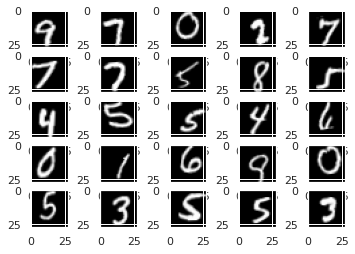

In [7]:
# plot first few images
for i in range(25):
	# define subplot
	pyplot.subplot(5, 5, i+1)
	# plot raw pixel data
	pyplot.imshow(train_generator[i][0][0], cmap=pyplot.get_cmap('gray'))
# show the figure
pyplot.show()

## The CNN modeling and evaluation

### Model


Model : we have to avoid overfitting

Softmax :  Softmax takes a set of values, and effectively picks the biggest one, so, for example, if the output of the last layer looks like [0.1, 0.1, 0.05, 0.1, 9.5, 0.1, 0.05, 0.05, 0.05], it saves you from fishing through it looking for the biggest value, and turns it into [0,0,0,0,1,0,0,0,0] -- The goal is to save a lot of coding!
activation layer : tf.keras.layers.Dense(10, activation=tf.nn.softmax)])
10 : because we have ten classes

In [8]:

digit_model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28,3)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

2022-06-05 12:21:25.117912: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-05 12:21:25.117952: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-05 12:21:25.117978: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Data-Ana): /proc/driver/nvidia/version does not exist
2022-06-05 12:21:25.118236: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Summarize Model


    The layers and their order in the model.

    The output shape of each layer.

    The number of parameters (weights) in each layer.

    The total number of parameters (weights) in the model.

In [9]:
digit_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 256)               4

#### Visualize a Deep Learning Neural Network Model in Keras

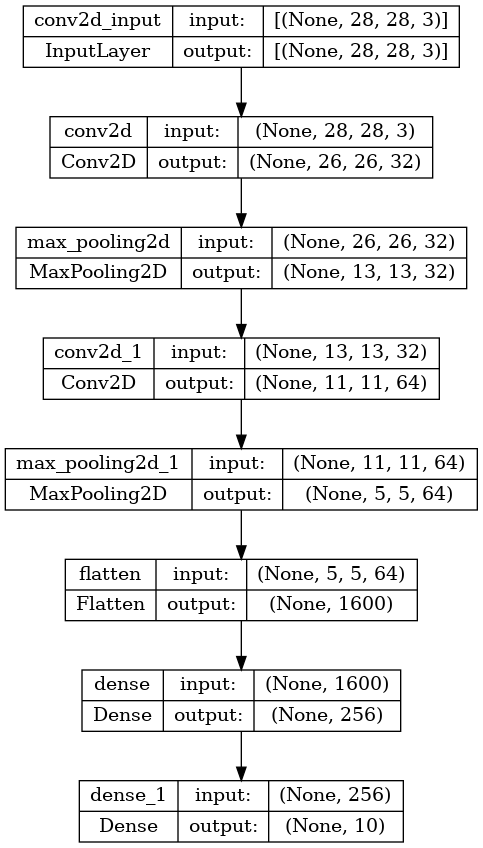

In [10]:
plot_model(digit_model, to_file='/home/azureuser/digit_data/benchmarks/model_plot_letter_1.png', show_shapes=True, show_layer_names=True)

#### compile the model
Following the results got by  https://github.com/sanghvirajit/Feedforward_Neural_Network
We make the choice of the RMSprop optimizer


In [11]:
optimizer = tf.keras.optimizers.RMSprop(lr=0.001)

digit_model.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

/home/azureuser/.local/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


#### Train the model

Reduce learning rate when a metric has stopped improving,we will gain in time while fitting the model by converging faster to the global minimum by decreasing the learning rate.
Set a learning rate annealer. we chose to decrease by 75%

In [12]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3, # number of epochs with no improvement after which learning rate will be reduced.
                                            verbose=1, #update messages
                                            factor=0.25, #new_lr = lr * factor`.
                                            min_lr=0.00001 # minimum learning rate
                                            )

### Fit model

In [13]:
history = digit_model.fit(train_generator, epochs=25, 
        validation_data=validation_generator,  callbacks=[learning_rate_reduction])

Epoch 1/25
470/470 [==============================] - 80s 168ms/step - loss: 0.3238 - accuracy: 0.8966 - val_loss: 0.1449 - val_accuracy: 0.9551 - lr: 0.0010
Epoch 2/25
470/470 [==============================] - 95s 202ms/step - loss: 0.0976 - accuracy: 0.9695 - val_loss: 0.0836 - val_accuracy: 0.9734 - lr: 0.0010
Epoch 3/25
470/470 [==============================] - 127s 271ms/step - loss: 0.0689 - accuracy: 0.9787 - val_loss: 0.0681 - val_accuracy: 0.9777 - lr: 0.0010
Epoch 4/25
470/470 [==============================] - 127s 270ms/step - loss: 0.0581 - accuracy: 0.9815 - val_loss: 0.0572 - val_accuracy: 0.9824 - lr: 0.0010
Epoch 5/25
470/470 [==============================] - 97s 207ms/step - loss: 0.0513 - accuracy: 0.9842 - val_loss: 0.0650 - val_accuracy: 0.9807 - lr: 0.0010
Epoch 6/25
470/470 [==============================] - 65s 138ms/step - loss: 0.0477 - accuracy: 0.9857 - val_loss: 0.0567 - val_accuracy: 0.9801 - lr: 0.0010
Epoch 7/25
470/470 [==============================

## plot  curves

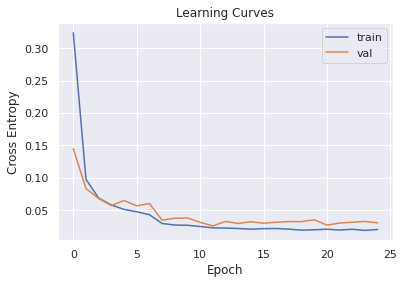

In [14]:

pyplot.title('Learning Curves')
pyplot.xlabel('Epoch')
pyplot.ylabel('Cross Entropy')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()

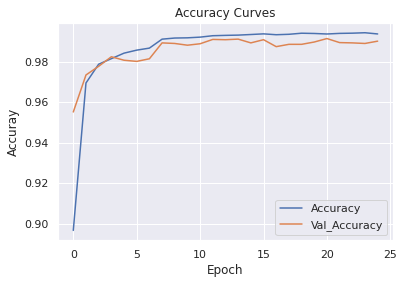

In [15]:
pyplot.title('Accuracy Curves')
pyplot.xlabel('Epoch')
pyplot.ylabel('Accuray')
pyplot.plot(history.history['accuracy'], label='Accuracy')
pyplot.plot(history.history['val_accuracy'], label='Val_Accuracy')
pyplot.legend()
pyplot.show()


## Confusion matrix

In [16]:

test_generator.reset()
pred_list=[ ] # will store the predicted classes here
true_list=[]
classes=list(test_generator.class_indices.keys()) # ordered lst of class names 
prediction = digit_model.predict(test_generator)
predictions = prediction.argmax(axis=1)
labels=test_generator.labels
for i, p in enumerate (prediction):
    index=np.argmax(p)
    pred_list.append(classes[index])
    true_list.append(classes[labels[i]])
y_pred=np.array(pred_list)
y_true=np.array(true_list)



14000/14000 [==============================] - 50s 4ms/step


<AxesSubplot:>

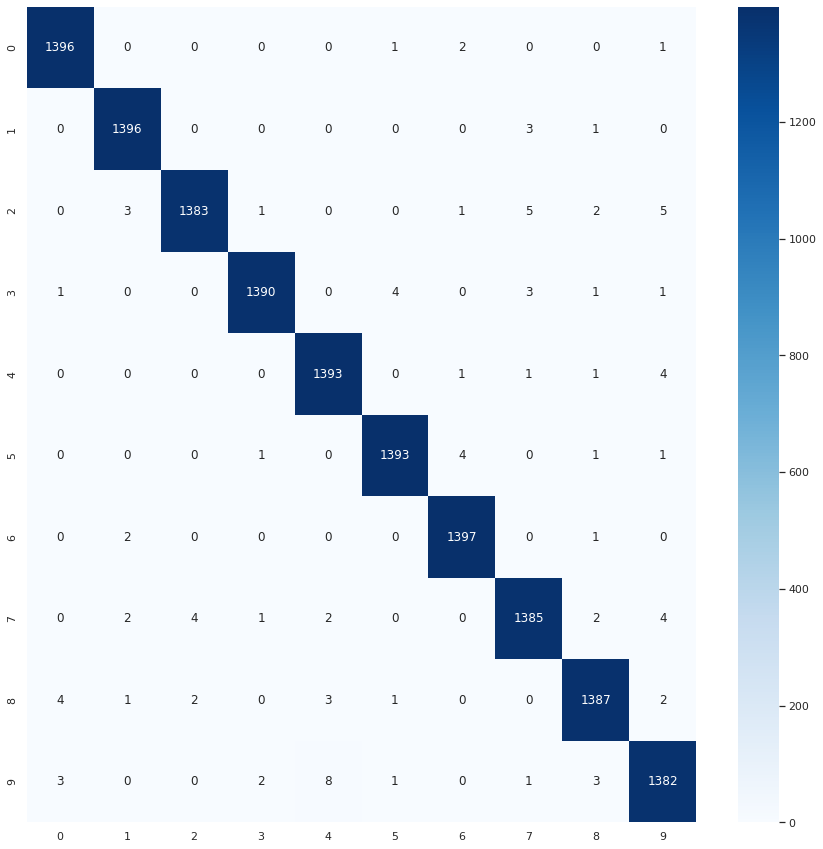

In [17]:
sns.set(rc = {'figure.figsize':(15,15)})
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm,annot=True, fmt='g', cmap='Blues')

## Model Evaluation

In [18]:
##TODO

test_generator.reset()
# Evaluate on Validation data
scores = digit_model.evaluate(test_generator)
print("%s%s: %.2f%%" % ("evaluate ",digit_model.metrics_names[1], scores[1]*100))


14000/14000 [==============================] - 55s 4ms/step - loss: 0.0263 - accuracy: 0.9923
evaluate accuracy: 99.23%


In [19]:
predict_model("/home/azureuser/digit_data/testing/0/7410.png",digit_model)

(28, 28, 3)
1/1 [==============================] - 0s 93ms/step
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[0]


0

In [20]:
predict_model("/home/azureuser/digit_data/testing/2/3627.png",digit_model)

(28, 28, 3)
1/1 [==============================] - 0s 55ms/step
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]
[2]


2

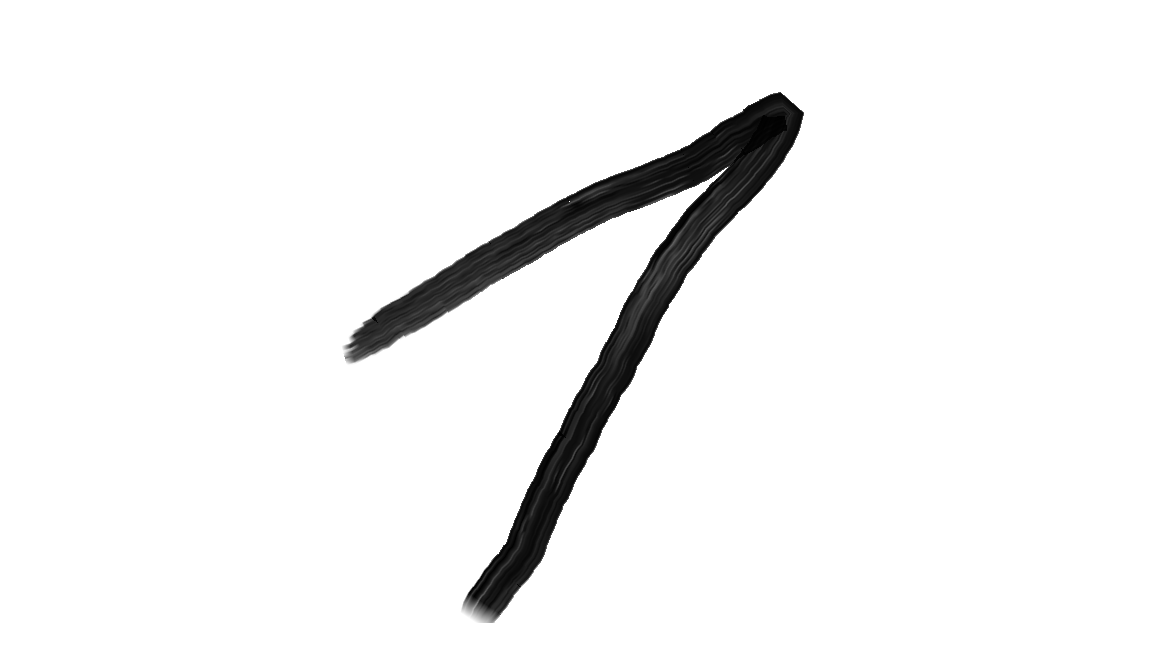

(255, 255, 255)
-57
-57
-60
-120
-123
-108
-84
-117
-183
-198
-177
-129
-57
-51
-66
-102
-126
-159
-237
-198
-255
-267
-240
-159
-72
-84
-123
-174
-186
-222
-285
-360
-342
-162
-132
-114
-294
-330
-333
-306
-174
-105
-120
-189
-237
-243
-279
-330
-399
-321
-186
-180
-141
-81
-201
-366
-414
-399
-333
-171
-141
-171
-261
-294
-297
-324
-372
-435
-315
-231
-222
-171
-114
-57
-312
-444
-495
-462
-339
-150
-180
-243
-345
-348
-348
-366
-411
-423
-318
-276
-255
-201
-147
-90
-99
-99
-75
-144
-438
-531
-561
-525
-330
-186
-222
-321
-411
-399
-393
-399
-444
-423
-339
-318
-285
-234
-177
-108
-153
-216
-189
-153
-114
-84
-78
-333
-531
-621
-621
-558
-303
-225
-270
-408
-465
-450
-426
-432
-471
-435
-384
-357
-315
-267
-210
-114
-60
-177
-318
-312
-279
-222
-177
-147
-282
-516
-588
-639
-627
-480
-240
-270
-351
-504
-516
-489
-453
-465
-489
-459
-423
-393
-351
-297
-240
-102
-69
-174
-378
-441
-411
-345
-279
-240
-267
-456
-573
-633
-633
-582
-375
-291
-327
-456
-573
-555
-516
-468
-492
-507
-49

(28, 28, 3)
1/1 [==============================] - 0s 54ms/step
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
[7]


7

In [21]:
predict_model("/home/azureuser/digit_data/validation_statique/1.png",digit_model)

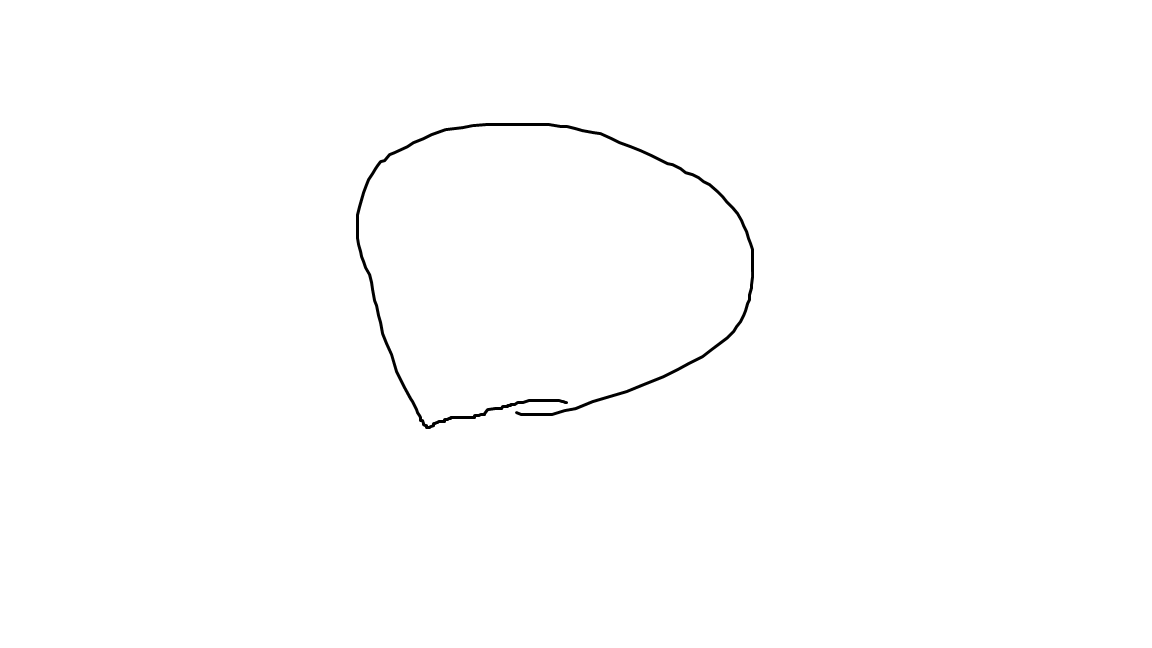

(255, 255, 255)
-144
-336
-525
-717
-765
-765
-765
-765
-765
-765
-765
-765
-765
-765
-765
-765
-765
-765
-765
-765
-765
-765
-765
-765
-765
-765
-765
-741
-597
-453
-336
-216
-72
-144
-336
-525
-717
-765
-765
-765
-765
-765
-765
-765
-765
-765
-765
-765
-765
-765
-765
-765
-765
-765
-765
-765
-765
-765
-765
-765
-765
-765
-765
-765
-765
-765
-765
-765
-765
-765
-717
-525
-336
-96
-72
-288
-501
-717
-765
-765
-765
-765
-765
-765
-765
-765
-765
-765
-765
-765
-765
-765
-765
-765
-765
-765
-765
-765
-765
-765
-765
-765
-765
-765
-765
-765
-765
-765
-765
-765
-765
-765
-765
-765
-765
-765
-765
-765
-765
-669
-453
-240
-192
-384
-621
-765
-765
-765
-765
-765
-765
-765
-765
-717
-525
-336
-144
-168
-312
-429
-549
-693
-765
-765
-765
-765
-765
-765
-765
-741
-597
-429
-288
-144
-72
-288
-501
-717
-765
-765
-765
-765
-765
-765
-765
-717
-525
-336
-144
-72
-288
-501
-717
-765
-765
-765
-765
-765
-765
-765
-765
-741
-525
-240
-168
-384
-597
-765
-765
-765
-765
-765
-765
-765
-765
-597
-384
-168

(28, 28, 3)
1/1 [==============================] - 0s 62ms/step
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[0]


0

In [22]:
predict_model("/home/azureuser/digit_data/validation_statique/my0.png",digit_model)

In [25]:
predict_model("/home/azureuser/digit_data/testing/0/7410.png",digit_model)

(28, 28, 3)
1/1 [==============================] - 0s 85ms/step
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[0]


0

In [28]:
digit_model.save("/home/azureuser/DataAnalyzer/src/digit_model.h5")